# Train a worm segmentation network

Training data is hand-drawn masks of worm in each frame. it gets augmented through rotations

`conda activate segment-torch`

See `eval_torch.py`

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import os
import glob
import random
import math
import tifffile
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import segmentation_models_pytorch as smp
from scipy.stats import zscore


c:\Users\munib\anaconda3\envs\segment-torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# -----------------------------
# Config
# -----------------------------
TRAIN_GLOB = r'training/*_label.tif'
WEIGHTS_PATH = 'deeplab_v3p_resnet50.pth'  # torch checkpoint
LEARNING_RATE = 5e-5
BATCH_SIZE = 4
# EPOCHS = 20 # Epoch 020 | val_loss: 0.020820
EPOCHS = 100 
VAL_SPLIT = 0.1
RNG_SEED = 42
NUM_WORKERS = 0  # Windows-safe default
LOG_DIR = r'runs/seg_logs'
# ----------------
# Early stopping
# ----------------
EARLY_PATIENCE = 8
early_counter = 0
# ----------------
# Learning rate scheduler
# ----------------
lrfactor=0.5,
lrpatience=3,
lrthreshold=1e-4,


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

Using device: cuda


In [3]:
# -----------------------------
# Helpers for I/O to match your original data layout
# -----------------------------
def label_to_class_indices(label_path: str) -> np.ndarray:
    """
    read the TIFF and convert to class indices [0, 1].
    """
    lab = tifffile.imread(label_path)
    # lab is expected boolean or 0/1 mask for foreground
    # ensure boolean
    lab_bool = lab.astype(bool)
    # class index: 1 where mask True, else 0
    return lab_bool.astype(np.int64)

def image_to_3ch_zscore(image_path: str) -> np.ndarray:
    """
    Read the RFP TIFF (single channel), z-score across all pixels,
    and replicate to 3 channels (H, W, 3)
    """
    rfp = tifffile.imread(image_path).astype(np.float32)
    rfp_z = zscore(rfp, axis=None)
    # handle any potential NaNs (e.g., constant image)
    if np.isnan(rfp_z).any():
        rfp_z = np.nan_to_num(rfp_z, nan=0.0)
    h, w = rfp.shape[-2], rfp.shape[-1] if rfp.ndim == 3 else rfp.shape[1]
    # Support (H, W) or (Z, H, W) by max projecting
    if rfp.ndim == 3:
        rfp_z = rfp_z.max(axis=0)
    image = np.stack([rfp_z, rfp_z, rfp_z], axis=-1).astype(np.float32)
    return image

# -----------------------------
# Dataset
# -----------------------------
class SegDataset(Dataset):
    def __init__(self, image_paths, label_paths, augment=True):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        lab_path = self.label_paths[idx]

        img = image_to_3ch_zscore(img_path)          # (H, W, 3), float32
        lab = label_to_class_indices(lab_path)       # (H, W), int64 in {0,1}

        # Random flips
        if self.augment:
            if random.randint(0, 1):
                img = img[::-1, :, :]
                lab = lab[::-1, :]
            if random.randint(0, 1):
                img = img[:, ::-1, :]
                lab = lab[:, ::-1]

        # To torch tensors: CHW for image, HW for label
        img_t = torch.from_numpy(img.copy()).permute(2, 0, 1).contiguous() # (3, H, W)
        lab_t = torch.from_numpy(lab.copy())      # (H, W), long class indices
        return img_t, lab_t

In [4]:
# -----------------------------
# Get data
# -----------------------------
label_paths = sorted(glob.glob(TRAIN_GLOB))
if len(label_paths) == 0:
    raise FileNotFoundError(f'No label files found with pattern: {TRAIN_GLOB}')
image_paths = [p[:-10] + '.tif' for p in label_paths]  # strip "_label.tif" -> ".tif"

# Quick shape sanity check on one sample
_debug_img = image_to_3ch_zscore(image_paths[0])
_debug_lab = label_to_class_indices(label_paths[0])
print('Sample image shape:', _debug_img.shape, 'label shape:', _debug_lab.shape)

Sample image shape: (512, 512, 3) label shape: (512, 512)


In [5]:
_debug_img.shape

(512, 512, 3)

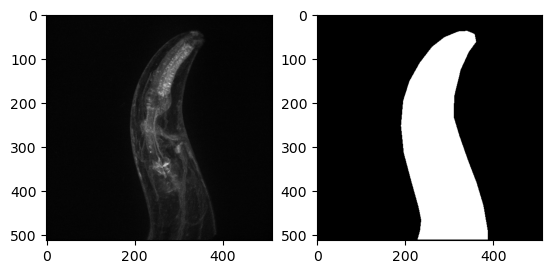

In [6]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(_debug_img[:,:,0],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(_debug_lab[:,:],cmap='gray')
plt.show()

In [7]:
# -----------------------------
# Dataset & Dataloaders
# -----------------------------
random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
np.random.seed(RNG_SEED)

dataset = SegDataset(image_paths, label_paths, augment=True)

val_len = max(1, int(len(dataset) * VAL_SPLIT))
train_len = len(dataset) - val_len
train_ds, val_ds = random_split(dataset, [train_len, val_len],
                                generator=torch.Generator().manual_seed(RNG_SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


In [10]:
# -----------------------------
# Model (DeepLabV3+ ResNet-50)
# -----------------------------
model = smp.DeepLabV3Plus(
    encoder_name='resnet50',       # backbone
    encoder_weights='imagenet',    # start from ImageNet weights
    in_channels=3,
    classes=2                      # background, foreground
).to(DEVICE)

# Loss & Optimizer
# We use CrossEntropyLoss on class indices (more stable than BCE on one-hot).
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ------------------------------------------------
# Add learning-rate scheduler (ReduceLROnPlateau)
# ------------------------------------------------
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    threshold=1e-4,
    # verbose=True
)

In [11]:
# Try to resume if a weights file exists
if os.path.isfile(WEIGHTS_PATH):
    print(f'Loading existing weights: {WEIGHTS_PATH}')
    ckpt = torch.load(WEIGHTS_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt.get('optimizer', optimizer.state_dict()))

# -----------------------------
# Training loop with TensorBoard
# -----------------------------
writer = SummaryWriter(LOG_DIR)

# ----------------
# Early stopping
# ----------------
EARLY_PATIENCE = 8
early_counter = 0

def evaluate(loader):
    model.eval()
    total_loss = 0.0
    n = 0
    with torch.no_grad():
        for imgs, labs in loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labs = labs.to(DEVICE, non_blocking=True)
            logits = model(imgs)
            loss = criterion(logits, labs)
            total_loss += float(loss.item()) * imgs.size(0)
            n += imgs.size(0)
    return total_loss / max(1, n)

best_val = math.inf
global_step = 0

try:
    for epoch in tqdm(range(1, EPOCHS + 1)):
        model.train()
        for imgs, labs in train_loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labs = labs.to(DEVICE, non_blocking=True)
            
            if imgs.shape[0] == 1:
                continue

            optimizer.zero_grad(set_to_none=True)
            logits = model(imgs)
            loss = criterion(logits, labs)
            loss.backward()
            optimizer.step()

            writer.add_scalar('train/loss', loss.item(), global_step)
            global_step += 1

        val_loss = evaluate(val_loader)
        writer.add_scalar('val/loss', val_loss, epoch)
        print(f'Epoch {epoch:03d} | val_loss: {val_loss:.6f}')

        # Step LR scheduler using validation loss
        scheduler.step(val_loss)

        # save best
        if val_loss < best_val - 1e-7:
            best_val = val_loss
            early_counter = 0
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': val_loss,
            }, WEIGHTS_PATH)
            print(f'  -> Saved best to {WEIGHTS_PATH}')
        else:
            early_counter += 1
            print(f'  -> No improvement ({early_counter}/{EARLY_PATIENCE})')

            if early_counter >= EARLY_PATIENCE:
                print('Early stopping triggered')
                break

except KeyboardInterrupt:
    print('Training interrupted')


Loading existing weights: deeplab_v3p_resnet50.pth


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001 | val_loss: 0.018819


  1%|          | 1/100 [00:09<15:46,  9.56s/it]

  -> Saved best to deeplab_v3p_resnet50.pth


  2%|▏         | 2/100 [00:15<12:01,  7.36s/it]

Epoch 002 | val_loss: 0.020218
  -> No improvement (1/8)


  3%|▎         | 3/100 [00:21<10:42,  6.62s/it]

Epoch 003 | val_loss: 0.020877
  -> No improvement (2/8)
Epoch 004 | val_loss: 0.018260


  4%|▍         | 4/100 [00:27<10:12,  6.38s/it]

  -> Saved best to deeplab_v3p_resnet50.pth
Epoch 005 | val_loss: 0.017606


  5%|▌         | 5/100 [00:33<09:51,  6.23s/it]

  -> Saved best to deeplab_v3p_resnet50.pth


  6%|▌         | 6/100 [00:38<09:28,  6.04s/it]

Epoch 006 | val_loss: 0.018654
  -> No improvement (1/8)
Epoch 007 | val_loss: 0.016879


  7%|▋         | 7/100 [00:44<09:20,  6.03s/it]

  -> Saved best to deeplab_v3p_resnet50.pth


  8%|▊         | 8/100 [00:50<09:05,  5.93s/it]

Epoch 008 | val_loss: 0.017927
  -> No improvement (1/8)
Epoch 009 | val_loss: 0.016282


  9%|▉         | 9/100 [00:56<09:04,  5.99s/it]

  -> Saved best to deeplab_v3p_resnet50.pth


 10%|█         | 10/100 [01:02<08:52,  5.92s/it]

Epoch 010 | val_loss: 0.018032
  -> No improvement (1/8)


 11%|█         | 11/100 [01:08<08:41,  5.86s/it]

Epoch 011 | val_loss: 0.016398
  -> No improvement (2/8)


 12%|█▏        | 12/100 [01:13<08:31,  5.81s/it]

Epoch 012 | val_loss: 0.016302
  -> No improvement (3/8)
Epoch 013 | val_loss: 0.015238


 13%|█▎        | 13/100 [01:19<08:32,  5.89s/it]

  -> Saved best to deeplab_v3p_resnet50.pth


 14%|█▍        | 14/100 [01:25<08:23,  5.85s/it]

Epoch 014 | val_loss: 0.016245
  -> No improvement (1/8)


 15%|█▌        | 15/100 [01:31<08:15,  5.83s/it]

Epoch 015 | val_loss: 0.017797
  -> No improvement (2/8)


 16%|█▌        | 16/100 [01:37<08:07,  5.80s/it]

Epoch 016 | val_loss: 0.017304
  -> No improvement (3/8)


 17%|█▋        | 17/100 [01:42<08:00,  5.79s/it]

Epoch 017 | val_loss: 0.015797
  -> No improvement (4/8)
Epoch 018 | val_loss: 0.015046


 18%|█▊        | 18/100 [01:48<08:01,  5.87s/it]

  -> Saved best to deeplab_v3p_resnet50.pth


 19%|█▉        | 19/100 [01:54<07:52,  5.83s/it]

Epoch 019 | val_loss: 0.016148
  -> No improvement (1/8)


 20%|██        | 20/100 [02:00<07:45,  5.82s/it]

Epoch 020 | val_loss: 0.015268
  -> No improvement (2/8)


 21%|██        | 21/100 [02:06<07:39,  5.81s/it]

Epoch 021 | val_loss: 0.015618
  -> No improvement (3/8)


 22%|██▏       | 22/100 [02:12<07:33,  5.81s/it]

Epoch 022 | val_loss: 0.015331
  -> No improvement (4/8)


 23%|██▎       | 23/100 [02:17<07:25,  5.79s/it]

Epoch 023 | val_loss: 0.015300
  -> No improvement (5/8)


 24%|██▍       | 24/100 [02:23<07:19,  5.79s/it]

Epoch 024 | val_loss: 0.015514
  -> No improvement (6/8)
Epoch 025 | val_loss: 0.014681


 25%|██▌       | 25/100 [02:29<07:20,  5.87s/it]

  -> Saved best to deeplab_v3p_resnet50.pth


 26%|██▌       | 26/100 [02:35<07:12,  5.84s/it]

Epoch 026 | val_loss: 0.015237
  -> No improvement (1/8)


 27%|██▋       | 27/100 [02:41<07:05,  5.82s/it]

Epoch 027 | val_loss: 0.015066
  -> No improvement (2/8)


 28%|██▊       | 28/100 [02:47<06:58,  5.81s/it]

Epoch 028 | val_loss: 0.015836
  -> No improvement (3/8)


 29%|██▉       | 29/100 [02:52<06:50,  5.78s/it]

Epoch 029 | val_loss: 0.015800
  -> No improvement (4/8)


 30%|███       | 30/100 [02:58<06:44,  5.77s/it]

Epoch 030 | val_loss: 0.015371
  -> No improvement (5/8)


 31%|███       | 31/100 [03:04<06:38,  5.77s/it]

Epoch 031 | val_loss: 0.015460
  -> No improvement (6/8)


 32%|███▏      | 32/100 [03:10<06:33,  5.78s/it]

Epoch 032 | val_loss: 0.016038
  -> No improvement (7/8)


 32%|███▏      | 32/100 [03:15<06:56,  6.12s/it]

Epoch 033 | val_loss: 0.015698
  -> No improvement (8/8)
Early stopping triggered


Random example index: 102


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6371006..19.923256].


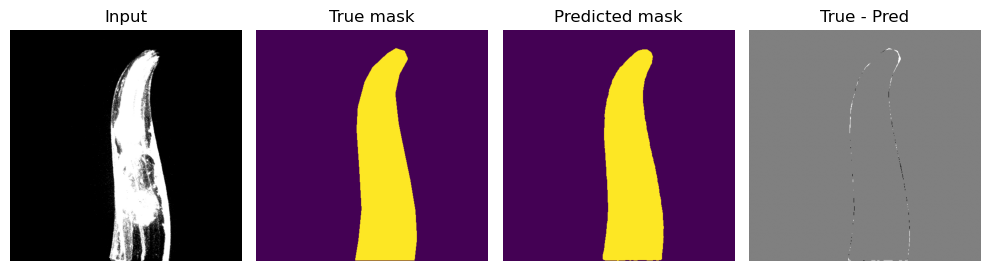

In [19]:
# -----------------------------
# Quick visualization 
# -----------------------------
# pick a random image from the whole set
i = np.random.randint(0, len(image_paths))
print('Random example index:', i)

with torch.no_grad():
    model.eval()
    img_np = image_to_3ch_zscore(image_paths[i])  # (H, W, 3)
    img_t = torch.from_numpy(img_np).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
    logits = model(img_t)               # (1, 2, H, W)
    pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
true_label = label_to_class_indices(label_paths[i])

plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.title('Input')
plt.imshow(img_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('True mask')
plt.imshow(true_label, cmap='viridis')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Predicted mask')
plt.imshow(pred, cmap='viridis')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('True - Pred')
plt.imshow(true_label-pred, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()